In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


In [49]:
# Read in CSV File
document_check = 'document_check_sample.csv'
facial_report = 'facial_report_sample.csv'

document_df = pd.read_csv(document_check)
facial_df = pd.read_csv(facial_report)


## Understand the attributes of data frames: 
- What are the attributes 
- What are their unique values 

In [50]:
# Understand the attributes
document_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11760 entries, 0 to 11759
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          5880 non-null   float64
 1   user_id                             5880 non-null   object 
 2   result                              5880 non-null   object 
 3   visual_authenticity_result          4991 non-null   object 
 4   image_integrity_result              5880 non-null   object 
 5   face_detection_result               4990 non-null   object 
 6   image_quality_result                5880 non-null   object 
 7   created_at                          5880 non-null   object 
 8   supported_document_result           5869 non-null   object 
 9   conclusive_document_quality_result  3140 non-null   object 
 10  colour_picture_result               3140 non-null   object 
 11  data_validation_result              4739 

## Dropping Nan vales 
- Based on the information above, there are 11760 entries, however there are only 5880 rows with result. Which means we canont make any assumption out of the rows with no result
- Hence, I will decide to drop all those rows

In [51]:
# Dropping the rows with Na values for result
document_df = document_df.dropna(subset=['result']).reset_index(drop=True)
facial_df = facial_df.dropna(subset=['result']).reset_index(drop=True)



## Handling document file
Things we will do to the document file 
- Keep only relevant attributes 
- This is a time series problem -> ensure the date time format, sort the data according to the time 
- Generate visualization to understand how each attribute change over time 
- Handle the attribute property separately due to difference data type
- Select the attribute with noticable changes that might affect the final result 
- Confirm the assumption about that attribute using chi-square techniche: finding the relevance of categorical data 

In [52]:
# Remmove unrelevant attributes

document_importantAttr = [
 'result', 
 'visual_authenticity_result',
 'image_integrity_result',
 'face_detection_result',
 'image_quality_result',
 'created_at',
 'supported_document_result',
 'conclusive_document_quality_result',
 'colour_picture_result',
 'data_validation_result',
 'data_consistency_result',
 'data_comparison_result',
 'police_record_result',
 'compromised_document_result',
 'properties']

In [53]:
# Currently, the date time is object so it will not be sorted correctly. We will convert that to date-time format

document_df['created_at'] = pd.to_datetime(document_df['created_at'], format='%d/%m/%Y %H:%M')
document_df['created_at'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 5880 entries, 0 to 5879
Series name: created_at
Non-Null Count  Dtype         
--------------  -----         
5880 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 46.1 KB


In [54]:
# Since the result recently decreased, sort the dataset by date 'created_at' 

document_filtered = document_df[document_importantAttr]
document_filtered = document_filtered.sort_values(by='created_at').reset_index(drop=True)

In [55]:
# Check the unique values in all attributes 
# This step helps understanding what are in each attributes, then we can create suitable visualization

for attribute in document_importantAttr:
    unique_values = document_filtered[attribute].unique()
    print(f"Unique values for {attribute}:\n{unique_values}\n")


Unique values for result:
['clear' 'consider']

Unique values for visual_authenticity_result:
['clear' 'consider' nan]

Unique values for image_integrity_result:
['clear' 'consider']

Unique values for face_detection_result:
['clear' nan 'consider']

Unique values for image_quality_result:
['clear' 'unidentified']

Unique values for created_at:
<DatetimeArray>
['2017-05-23 17:25:00', '2017-05-23 19:17:00', '2017-05-23 20:49:00',
 '2017-05-24 07:47:00', '2017-05-24 11:38:00', '2017-05-24 18:31:00',
 '2017-05-24 19:31:00', '2017-05-24 19:47:00', '2017-05-24 20:00:00',
 '2017-05-24 20:03:00',
 ...
 '2017-10-31 19:14:00', '2017-10-31 19:29:00', '2017-10-31 19:53:00',
 '2017-10-31 20:03:00', '2017-10-31 20:37:00', '2017-10-31 21:06:00',
 '2017-10-31 21:10:00', '2017-10-31 21:11:00', '2017-10-31 21:46:00',
 '2017-10-31 22:06:00']
Length: 5737, dtype: datetime64[ns]

Unique values for supported_document_result:
['clear' nan 'unidentified']

Unique values for conclusive_document_quality_result

In [56]:
# Create a pipeline to group by created date to see the trend 
def groupping(divided_doc, value):
    divided_doc[value] = divided_doc[value].fillna('null')
    result_counts = divided_doc.resample('M', on='created_at')[value].value_counts().unstack()
    result_counts.index = result_counts.index.strftime('%Y-%m')
    return result_counts

/var/folders/l9/lgcrjc856bb1g071byrjw6rr0000gn/T/ipykernel_78319/2301333759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  divided_doc[value] = divided_doc[value].fillna('null')
/var/folders/l9/lgcrjc856bb1g071byrjw6rr0000gn/T/ipykernel_78319/2301333759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  divided_doc[value] = divided_doc[value].fillna('null')
/var/folders/l9/lgcrjc856bb1g071byrjw6rr0000gn/T/ipykernel_78319/2301333759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy o

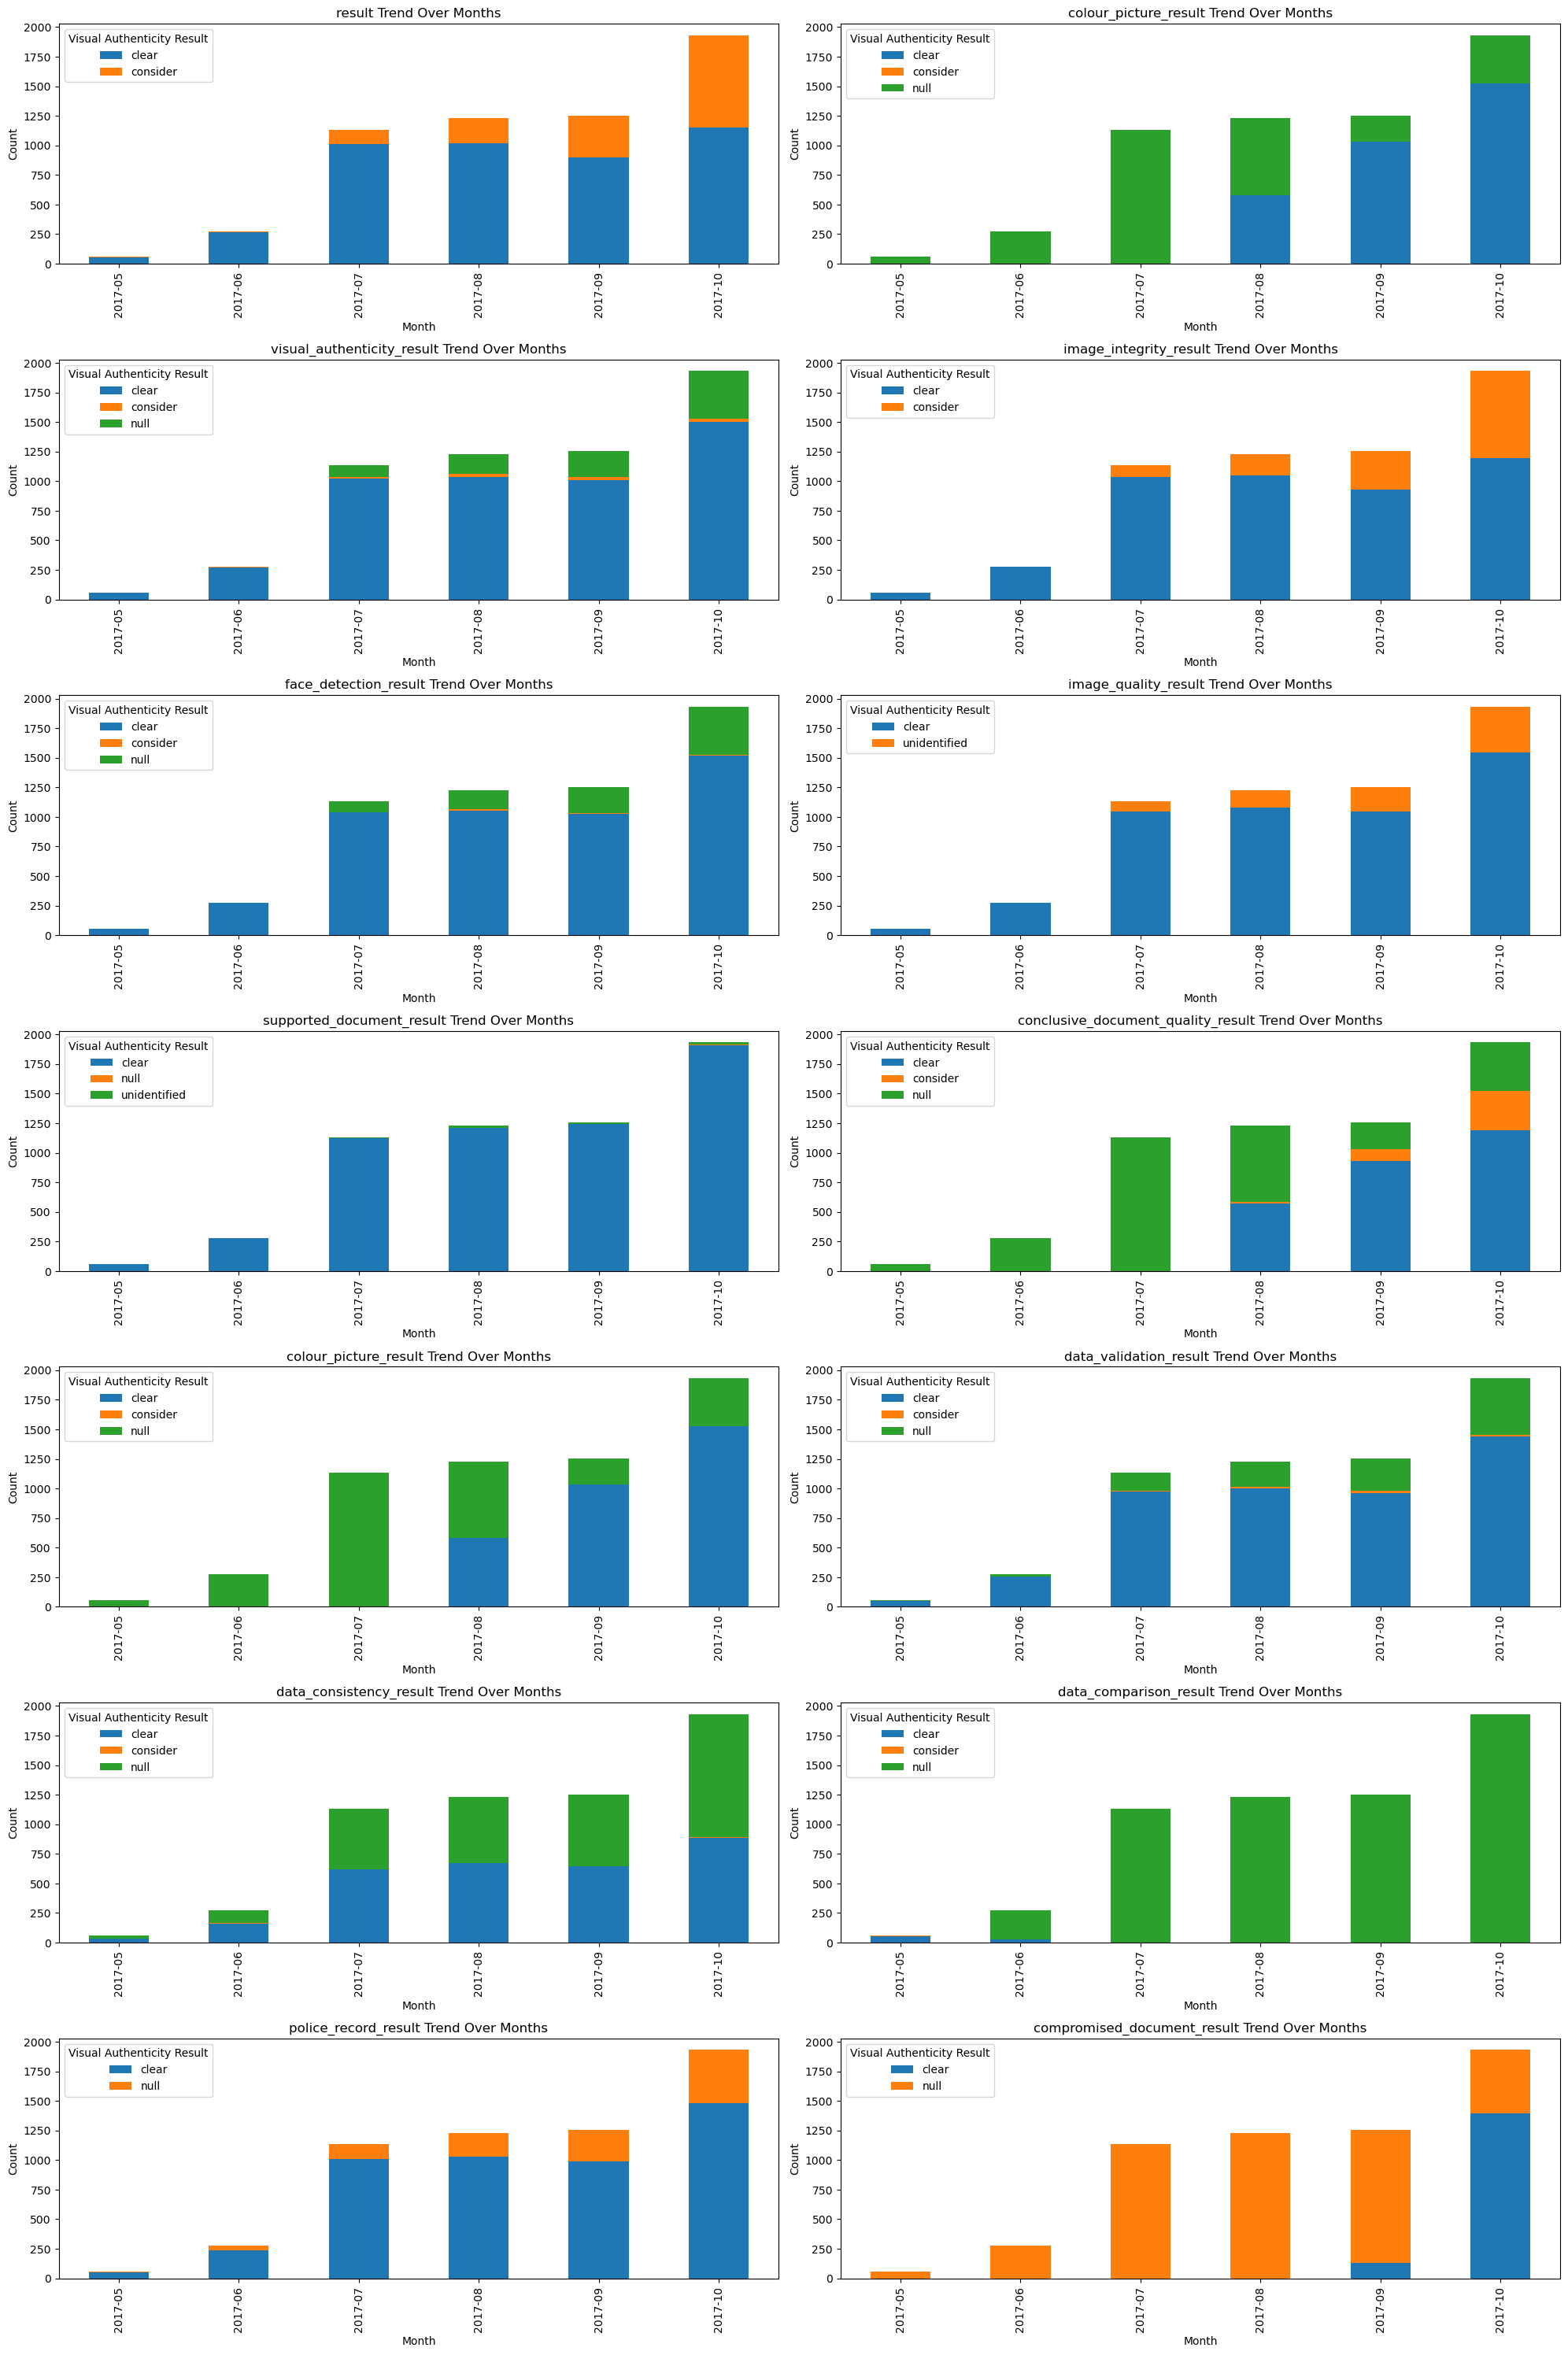

In [57]:
def plotting(result_counts, value, ax):
    result_counts.plot(kind='bar', stacked=True, figsize=(20, 30), ax=ax)

    # Add labels and title
    ax.set_title(value + ' Trend Over Months')
    ax.set_xlabel('Month')
    ax.set_ylabel('Count')
    ax.legend(title='Visual Authenticity Result')

# List of attribute to create plots
attr = ['result', 'colour_picture_result', 'visual_authenticity_result', 'image_integrity_result', 'face_detection_result', 'image_quality_result', 'supported_document_result', 'conclusive_document_quality_result', 'colour_picture_result',
 'data_validation_result',
 'data_consistency_result',
 'data_comparison_result',
 'police_record_result',
 'compromised_document_result' ]

# Set the number of columns for subplots
num_cols = 2
num_rows = -(-len(attr) // num_cols)  

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axs array in case there is only one row
axs = axs.flatten()

# Loop through attributes and create subplots
for i, value in enumerate(attr):
    divide = ['created_at', value]
    divided_doc = document_filtered[divide]
    result_counts = groupping(divided_doc, value)

    plotting(result_counts, value, axs[i])


plt.tight_layout(pad=1.0)
plt.show()


### Explain visualization
#### Why
- From the visualization above, we can see the trend how each attribute changes over time, which one has signigicant changes that might affect the final result
- After remove the inrellevant attribute, we can move on further with the rest
#### Understand the attributes
- colour_picture_result: This could be the result for colored photo, which means they take in and analyze the colored photos 
- visual_authenticity_result: Elements such as watermark are authentic. 
- image_integrity_result: Checking for any sign of tempering with the image 
- face_detection_result: Ensure the document contain the valid image. 
- image_quality_result: Overall quality of the image 
- supported_document_result: Any supported document provided along 
- conclusive_document_quality_result: Focus more on the quality of the entire document
- data_validation_result: Check validity of data occur 
- data_consistency_result: Consistency of data across the entire document
- data_comparison_result: Compare with external databasese
- police_record_result: Check if the data is in police record
- compromised_document_result: Check if the document has been compormsed

#### What can we keep 
From the visualization, it is evident that some attributes, namely 'color_picture_result,' 'image_integrity_result,' and 'compromised_document_result,' exhibit significant changes that warrant further examination. However, the attribute 'compromised_document_result' has changed positively, with more documents now marked as clear. Therefore, my assumption is that the system, when using colored images, detects more image integrity issues, leading to a reduction in the number of rejected documents.

### Analyze the realtion between 'result' and 'image_integrity_result' 

- We will use chi-square technique to identify the relation between this attribute and the final result

In [58]:
contingency_table = pd.crosstab(document_filtered['result'], document_filtered['image_integrity_result'])

print(contingency_table)

# Perform the chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

print()
print(f"Chi-square: {chi2}")
print(f"P-value: {p}")


image_integrity_result  clear  consider
result                                 
clear                    4406         0
consider                  137      1337

Chi-square: 5167.487097916589
P-value: 0.0


### Analyze attribute properties 

- Since attribute is in different format so it is better to do separate pre-processing as below: 

In [59]:
document_filtered['properties'].unique()

array(["{'gender': 'Female', 'document_type': 'driving_licence', 'date_of_expiry': '2024-03-03', 'issuing_country': 'GBR'}",
       "{'nationality': 'DEU', 'document_type': 'national_identity_card', 'date_of_expiry': '2020-11-19', 'issuing_country': 'DEU'}",
       "{'gender': 'Female', 'nationality': 'FRA', 'document_type': 'passport', 'date_of_expiry': '2024-01-22', 'issuing_country': 'FRA'}",
       ...,
       "{'gender': 'Male', 'issuing_date': '2012-08-31', 'document_type': 'driving_licence', 'date_of_expiry': '2021-09-17', 'issuing_country': 'GBR'}",
       "{'gender': 'Female', 'issuing_date': '2015-04-17', 'document_type': 'driving_licence', 'date_of_expiry': '2025-04-16', 'issuing_country': 'GBR'}",
       "{'issuing_date': '2002-09-18', 'document_type': 'driving_licence', 'issuing_country': 'POL'}"],
      dtype=object)

- We can summarize this to null and available (with properties) to see if missing the properties will affect the approval rate

In [60]:
document_filtered['properties'] = document_filtered['properties'].apply(lambda x: 'null' if not x or x == '{}' else 'available')

array(['available', 'null'], dtype=object)

In [69]:
attr_for_properties = ['created_at', 'properties']
df_for_properties = document_filtered[attr_for_properties]

In [74]:
result = df_for_properties.groupby([df_for_properties['created_at'].dt.to_period("M"), 'properties']).size().unstack(fill_value=0)
result.columns = ['Null', 'Available']

print(result)


            Null  Available
created_at                 
2017-05       58          0
2017-06      275          1
2017-07     1037         96
2017-08     1063        165
2017-09     1033        220
2017-10     1525        407


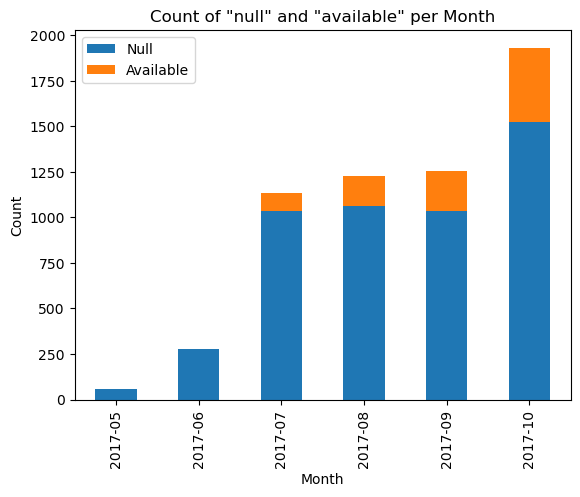

In [72]:
result.plot(kind='bar', stacked=True)
plt.title('Count of "null" and "available" per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()


#### Chi-square analysis for attribute properties

In [75]:
contingency_table = pd.crosstab(document_filtered['result'], document_filtered['properties'])

print(contingency_table)

# Perform the chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

print()
print(f"Chi-square: {chi2}")
print(f"P-value: {p}")

properties  available  null
result                     
clear            4406     0
consider          585   889

Chi-square: 3125.9809713860427
P-value: 0.0



Based on the results of the chi-square test, there is a statistically significant association between the 'result' and the 'properties' attributes.

The contingency table illustrates a notable disparity in the distribution of categories:

In the 'clear' result category, all 4406 documents have the 'properties' marked as available, with no instances of null properties.

In the 'consider' result category, 585 documents have available properties, while 889 documents have null properties.

The high chi-square statistic of 3125.98 indicates a substantial difference in the observed and expected frequencies, suggesting a significant association between the two attributes. The p-value of 0.0 reinforces this, indicating that the observed association is highly unlikely to occur by chance.

In conclusion, the 'properties' attribute appears to be closely related to the overall 'result' attribute. Specifically, the presence of available properties seems to be associated with a 'clear' result, while null properties are more prevalent in the 'consider' result category.


### Conclusion 1
Based on the chi-square test results, there is a statistically significant association between the 'result' and 'image_integrity_result' attributes.

The contingency table reveals a substantial discrepancy in the distribution of categories:
- In the 'clear' result category, the majority of documents (4406) are associated with 'clear' image integrity, and there are no instances of 'consider' image integrity.
- In the 'consider' result category, 137 documents have 'clear' image integrity, while 1337 documents have 'consider' image integrity.

The high chi-square statistic of 5167.49 indicates a significant difference in the observed and expected frequencies, supporting the notion that the two attributes are not independent. The p-value of 0.0 further corroborates this, suggesting that the association is unlikely to be due to chance.

Therefore, it appears that the 'image_integrity_result' attribute is related to the overall 'result' attribute. Specifically, the absence of 'clear' image integrity seems to be associated with a 'consider' result, while 'clear' image integrity is predominant in the 'clear' result category.

## Handling Facial Report File
Things we will do to the document file 
- Keep only relevant attributes 
- This is a time series problem -> ensure the date time format, sort the data according to the time 
- Generate visualization to understand how each attribute change over time 
- Select the attribute with noticable changes that might affect the final result 
- Confirm the assumption about that attribute using chi-square techniche: finding the relevance of categorical data 

In [61]:
facial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     5880 non-null   float64
 1   user_id                        5880 non-null   object 
 2   result                         5880 non-null   object 
 3   face_comparison_result         5535 non-null   object 
 4   created_at                     5880 non-null   object 
 5   facial_image_integrity_result  5861 non-null   object 
 6   visual_authenticity_result     4991 non-null   object 
 7   properties                     5880 non-null   object 
 8   attempt_id                     5880 non-null   object 
dtypes: float64(1), object(8)
memory usage: 413.6+ KB


In [62]:
# Currently, the date time is object so it will not be sorted correctly. We will convert that to date-time format

facial_df['created_at'] = pd.to_datetime(document_df['created_at'], format='%d/%m/%Y %H:%M')
facial_df['created_at'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 5880 entries, 0 to 5879
Series name: created_at
Non-Null Count  Dtype         
--------------  -----         
5880 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 46.1 KB


In [63]:
facial_importantArr = [
    'result', 
    'face_comparison_result',
    'created_at', 'facial_image_integrity_result',
    'visual_authenticity_result'
]

# Drop the inrellevant attributes 
facial_filtered = facial_df[facial_importantArr]
facial_filtered = facial_filtered.sort_values(by='created_at').reset_index(drop=True)

In [64]:
# Check the unique values in all attributes 
# This step helps understanding what are in each attributes, then we can create suitable visualization

for attribute in facial_importantArr:
    unique_values = facial_filtered[attribute].unique()
    # print(f"Unique values for {attribute}:\n{unique_values}\n")


/var/folders/l9/lgcrjc856bb1g071byrjw6rr0000gn/T/ipykernel_78319/2301333759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  divided_doc[value] = divided_doc[value].fillna('null')
/var/folders/l9/lgcrjc856bb1g071byrjw6rr0000gn/T/ipykernel_78319/2301333759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  divided_doc[value] = divided_doc[value].fillna('null')
/var/folders/l9/lgcrjc856bb1g071byrjw6rr0000gn/T/ipykernel_78319/2301333759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy o

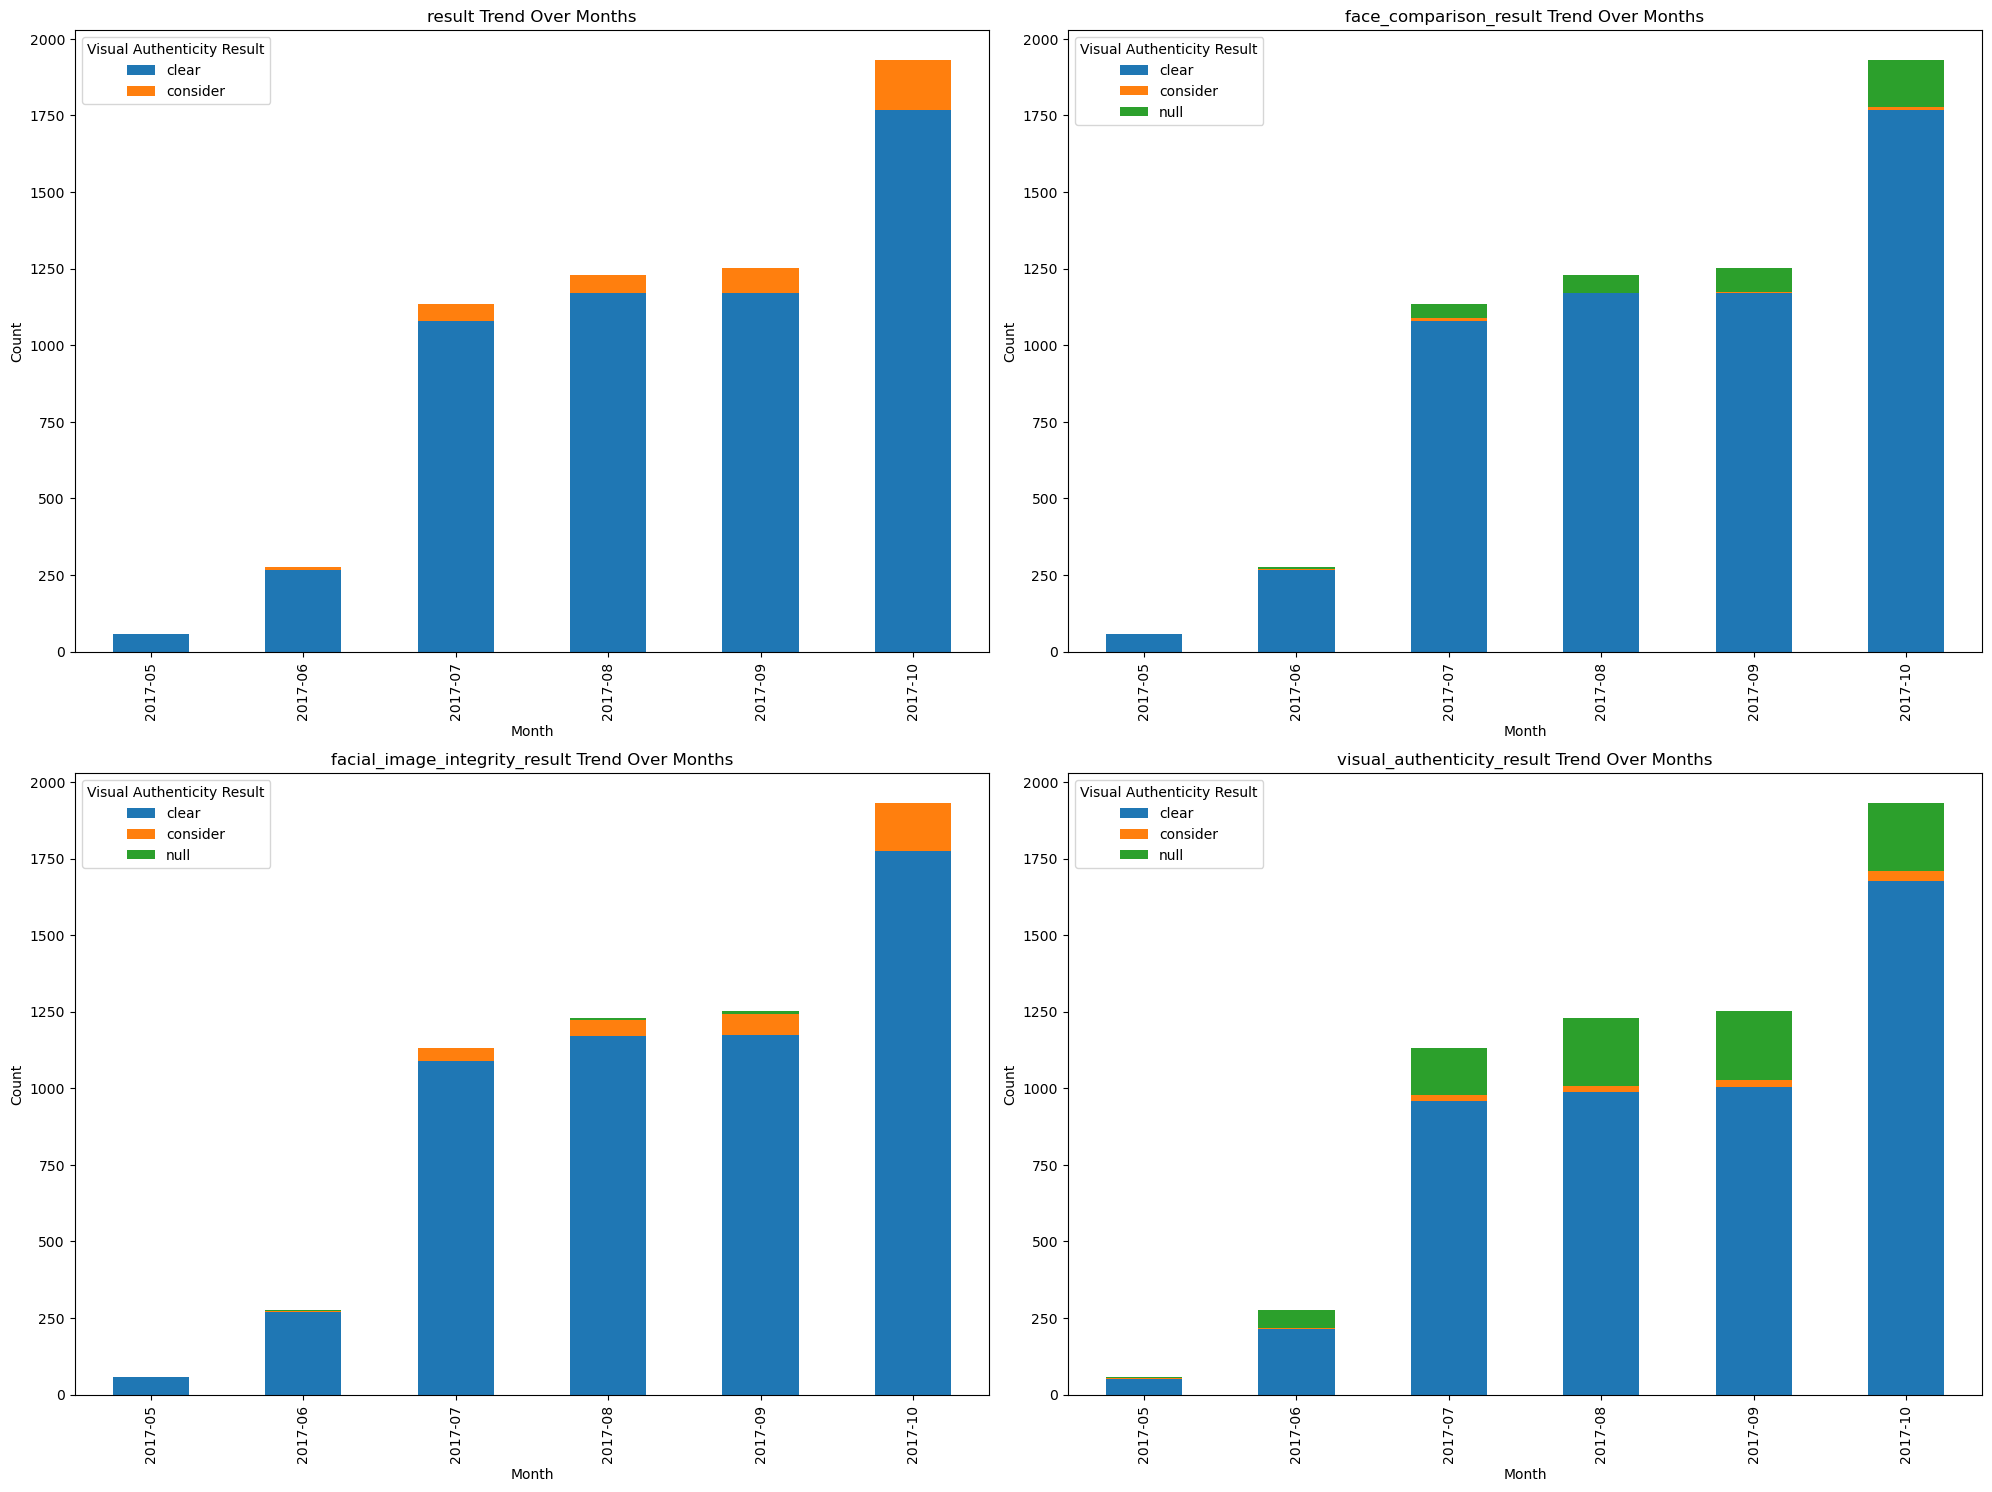

In [65]:
def plotting(result_counts, value, ax):
    result_counts.plot(kind='bar', stacked=True, figsize=(20, 15), ax=ax)

    # Add labels and title
    ax.set_title(value + ' Trend Over Months')
    ax.set_xlabel('Month')
    ax.set_ylabel('Count')
    ax.legend(title='Visual Authenticity Result')

# List of attribute to create plots
attr = ['result', 
    'face_comparison_result', 'facial_image_integrity_result', 'visual_authenticity_result' ]

# Set the number of columns for subplots
num_cols = 2
num_rows = -(-len(attr) // num_cols)  

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axs array in case there is only one row
axs = axs.flatten()

# Loop through attributes and create subplots
for i, value in enumerate(attr):
    divide = ['created_at', value]
    divided_doc = facial_filtered[divide]
    result_counts = groupping(divided_doc, value)

    plotting(result_counts, value, axs[i])


plt.tight_layout(pad=1.0)
plt.show()
